# solving elasticity on a 2D domain

In [1]:
! pip install deepxde

In [2]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [3]:
lmbd = 1.0
mu = 0.5
Q = 4.0
pi = torch.pi

In [4]:
geom=dde.geometry.Rectangle(xmin=[0,0],xmax=[1,1])

In [5]:
# exact solution
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))

In [6]:
# defining boundaries
def left_boundary(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def right_boundary(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def bottom_boundary(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0)

def top_boundary(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1)

In [7]:
# defining boundary conditions (displacement)
ux_top=dde.icbc.DirichletBC(geom, lambda x: 0, top_boundary, component=0)
ux_bottom=dde.icbc.DirichletBC(geom, lambda x: 0, bottom_boundary , component=0)
uy_left=dde.icbc.DirichletBC(geom, lambda x: 0, left_boundary, component=1)
uy_right=dde.icbc.DirichletBC(geom, lambda x: 0, right_boundary, component=1)
uy_bottom=dde.icbc.DirichletBC(geom, lambda x: 0, bottom_boundary, component=1)

# defining boundary conditions (traction)
sxx_left = dde.icbc.DirichletBC(geom, lambda x: 0, left_boundary, component=2)
sxx_right = dde.icbc.DirichletBC(geom, lambda x: 0, right_boundary, component=2)
syy_top = dde.icbc.DirichletBC(geom, lambda x: (2*mu+lmbd)*Q*np.sin(pi*x[:,0:1]), top_boundary, component=3)

boundaries=[ux_top,ux_bottom,uy_left,uy_right,uy_bottom,sxx_left,sxx_right,syy_top]

In [ ]:
# defining the body force
def fx(x):
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  return (
        -lmbd*(4*pi**2*torch.cos(2*pi*x[:,0:1])*torch.sin(pi*x[:,1:2])-Q*x[:,1:2]**3*pi*torch.cos(pi*x[:,0:1]))
        -mu*(pi**2*torch.cos(2*pi*x[:,0:1])*torch.sin(pi*x[:, 1:2])-Q*x[:,1:2]**3*pi*torch.cos(pi*x[:,0:1]))
        -8*mu*pi**2*torch.cos(2*pi*x[:,0:1])*torch.sin(pi*x[:,1:2])
        )


def fy(x):
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  return (
        lmbd*(3*Q*x[:,1:2]**2*torch.sin(pi*x[:,0:1])-2*pi**2*torch.cos(pi*x[:,1:2])*torch.sin(2*pi*x[:,0:1]))
        -mu*(2*pi**2*torch.cos(pi*x[:,1:2])*torch.sin(2*pi*x[:,0:1])+(Q*x[:,1:2]**4*pi**2*torch.sin(pi*x[:,0:1]))/4)
        +6*Q*mu*x[:,1:2]**2*torch.sin(pi*x[:,0:1])
        )

In [10]:
# defining pde
def pde(x,f):
  exx= dde.grad.jacobian(f , x , i=0 , j=0)
  eyy= dde.grad.jacobian(f , x , i=1 , j=1)
  exy= 0.5*(dde.grad.jacobian(f , x , i=0 , j=1)+dde.grad.jacobian(f , x , i=1 , j=0))

  sxx = exx*(2*mu + lmbd) + eyy*lmbd
  syy = eyy*(2*mu + lmbd) + exx*lmbd
  sxy = 2*exy*mu

  sxx_x = dde.grad.jacobian(f , x , i=2 , j=0)
  syy_y = dde.grad.jacobian(f , x , i=3 , j=1)
  sxy_y = dde.grad.jacobian(f , x , i=4 , j=1)
  sxy_x = dde.grad.jacobian(f , x , i=4 , j=0)

  momentum_x=sxx_x+sxy_y - fx(x)
  momentum_y=syy_y+sxy_x - fy(x)

  sterss_x = sxx - f[:, 2:3]
  sterss_y = syy - f[: , 3:4]
  stress_xy = sxy - f[: , 4:5]

  return [momentum_x,momentum_y,sterss_x,sterss_y,stress_xy]

In [11]:
data= dde.data.PDE(geom , pde , boundaries , num_domain=5000 , num_boundary=500 , solution=func , num_test=500)

In [12]:
# network
layers=[2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
net= dde.nn.PFNN(layers , "tanh" , "Glorot uniform")

In [13]:
# building the model
model= dde.Model(data , net)
model.compile('adam', lr=1e-3, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.364848 s

'compile' took 3.875593 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric   
0         [1.79e+03, 2.63e+02, 3.15e-01, 1.59e-01, 3.84e-02, 3.30e-02, 7.73e-02, 4.70e-02, 9.21e-02, 7.73e-02, 4.70e-02, 9.21e-02, 3.07e+01]    [1.78e+03, 2.62e+02, 3.10e-01, 1.53e-01, 3.26e-02, 3.30e-02, 7.73e-02, 4.70e-02, 9.21e-02, 7.73e-02, 4.70e-02, 9.21e-02, 3.07e+01]    [1.01e+00]    
1000      [2.22e-01, 7.95e-02, 3.39e-02, 4.45e-02, 1.27e-01, 5.39e-03, 7.06e-02, 7.08e-02, 2.19e-02, 7.79e-02, 3.99e-02, 1.73e-02, 3.87e-03]    [1.17e-01, 5.33e-02, 3.19e-02, 4.08e-02, 1.09e-01, 5.39e-03, 7.06e-02, 7.08e-02, 2.19e-02, 7.79e-02, 3.99e-02, 1.73e-02, 3.87e-03]    [3.78e

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


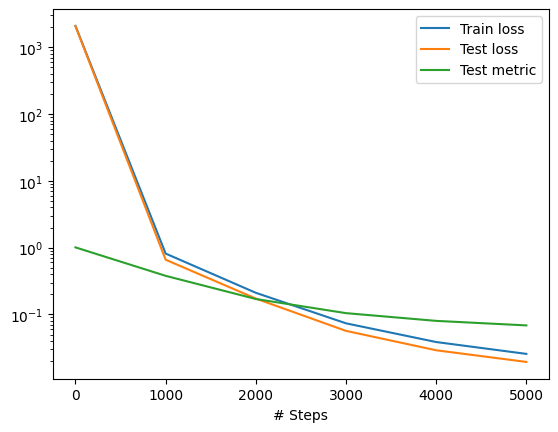

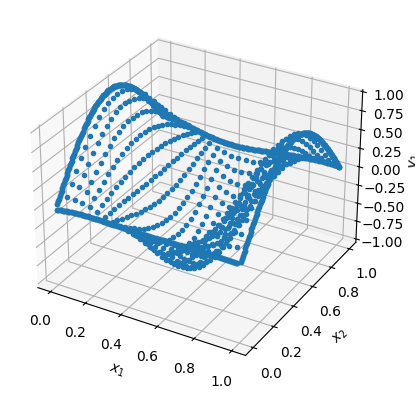

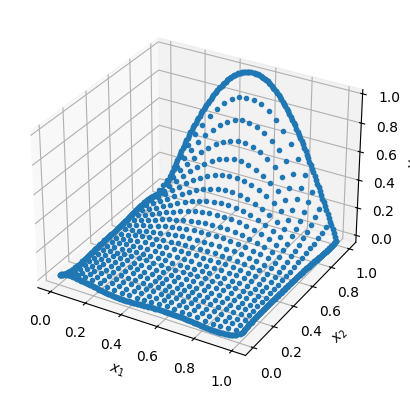

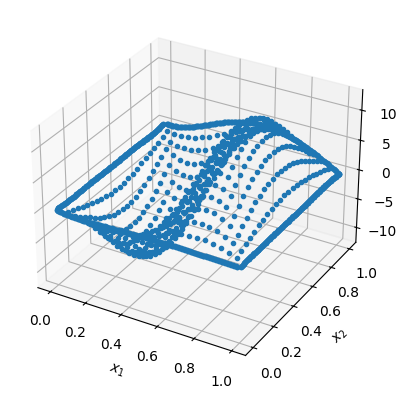

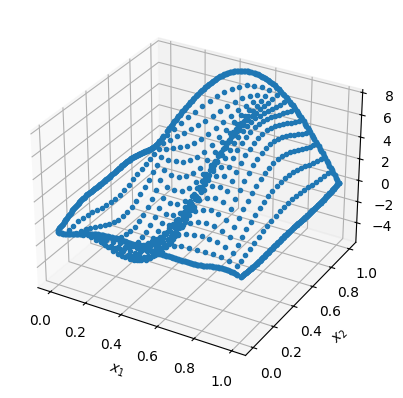

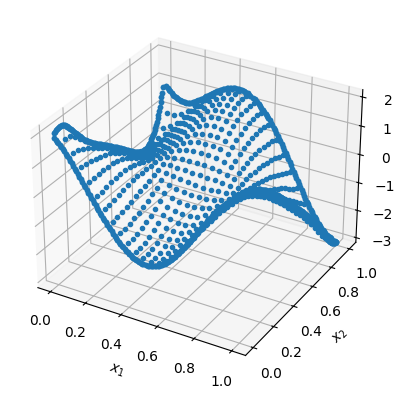

In [14]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

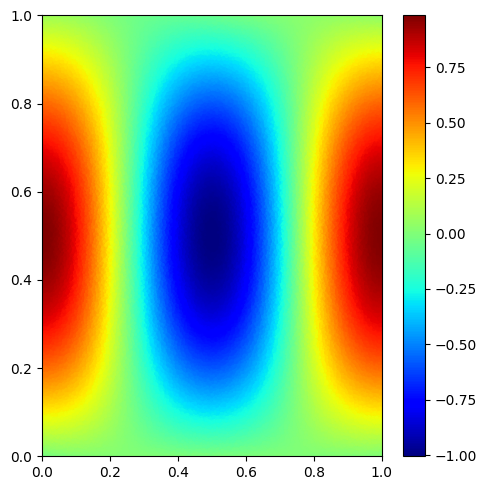

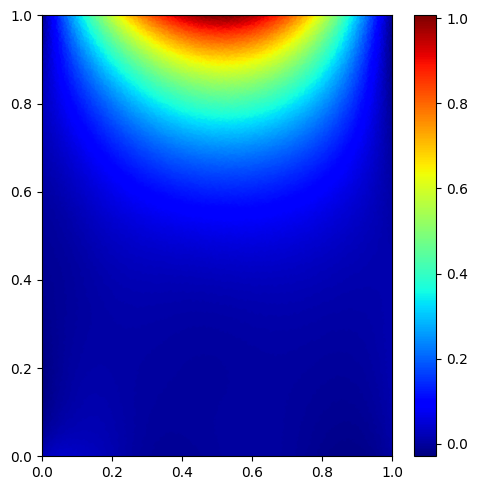

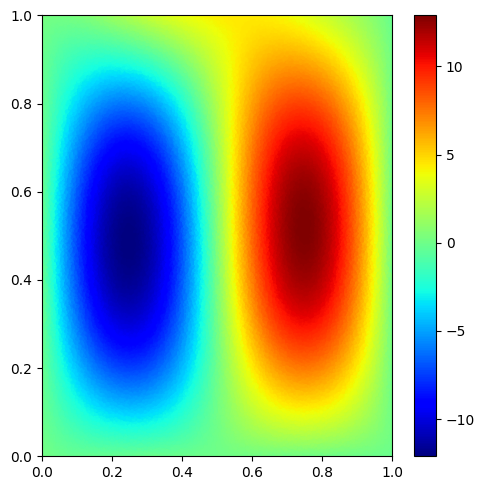

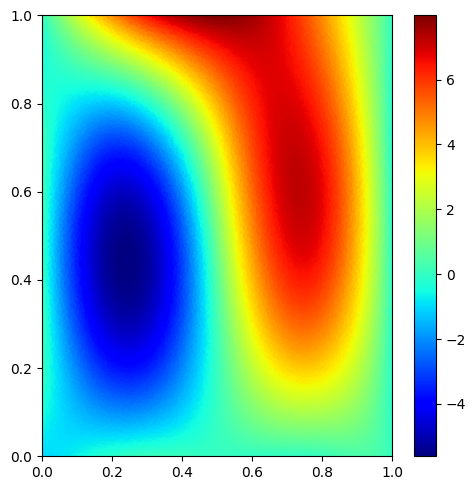

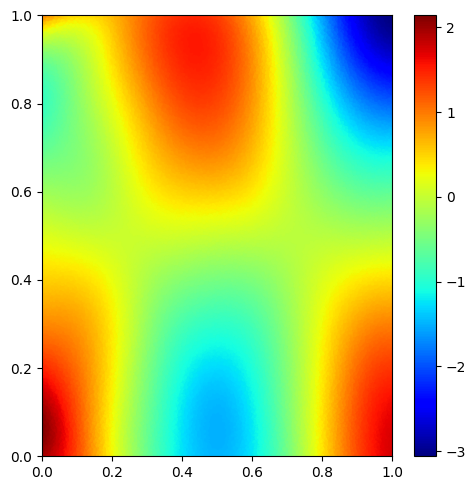

In [15]:
samples=geom.random_points(500000)
result=model.predict(samples)

for idx in range(5):
    plt.figure(figsize=(5,5))
    plt.scatter(samples[:,0], samples[:,1] , c=result[:,idx], cmap='jet' , s=2)
    plt.colorbar()
    #plt.clim(color_legend[idx])
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.tight_layout()
    string='plot num'+str(idx+1)
    plt.savefig(string)
    plt.show()